In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm  
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import pickle
import clip
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
from inference.models.grasp_model import GraspModel, ResidualBlock
from shapely.geometry import Polygon

Visualize the image with the grasping rectangle 

In [9]:

def visualize_grasp(image_path, grasp_file_path):
    # Load the image
    image = cv2.imread(image_path)

    # Load grasp data using PyTorch
    grasp_data = torch.load(grasp_file_path)

    for grasp_instance in grasp_data:
        print(grasp_instance)
        # Extract parameters from each grasp instance
        grasp_confidence, grasp_center_x, grasp_center_y, grasp_w, grasp_h, grasp_theta = grasp_instance.tolist()

        # Create a rotated rectangle using the calculated points
        rect = ((grasp_center_x, grasp_center_y), (grasp_w, grasp_h), grasp_theta)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # Draw the rectangle on the image
        cv2.drawContours(image, [box], 0, (0, 255, 0), 2)  # Green rectangle

    # Display the image with the grasp rectangles
    cv2.imshow("Image with Grasp", image)

    # Check for the window to be closed by the user
    while cv2.getWindowProperty("Image with Grasp", cv2.WND_PROP_VISIBLE) >= 1:
        key = cv2.waitKey(50)
        if key == 27:  # Press ESC to exit
            break

    # Close the OpenCV window
    cv2.destroyAllWindows()
# Example usage:
image_path = "/home/ericnguyen/eric/master_thesis/src/grasp-anything/new_dataset/positive_images/0a35d0fd13323ae715e670a5e5074f9b07b8d2f4e70a1a852fbf1814d728aff6.jpg"
grasp_file_path = "/home/ericnguyen/eric/master_thesis/src/grasp-anything/new_dataset/positive_grasp/0a35d0fd13323ae715e670a5e5074f9b07b8d2f4e70a1a852fbf1814d728aff6_0.pt"

visualize_grasp(image_path, grasp_file_path)


tensor([2.4180e-01, 3.1207e+02, 1.7927e+02, 1.6738e+02, 3.7112e+01, 1.8286e+01])
tensor([2.2193e-01, 2.7735e+02, 1.7888e+02, 1.8342e+02, 4.3059e+01, 1.6992e+02])
tensor([9.5972e-02, 3.1199e+02, 1.8036e+02, 1.7114e+02, 4.8742e+01, 1.6855e+02])
tensor([6.2602e-02, 2.7784e+02, 1.7790e+02, 1.8278e+02, 3.9815e+01, 1.8559e+01])
tensor([4.8610e-02, 2.4890e+02, 1.5289e+02, 1.6061e+02, 3.7830e+01, 1.7023e+02])
tensor([4.2725e-02, 2.5170e+02, 1.7719e+02, 1.6696e+02, 3.6233e+01, 1.9253e+01])


/tmp/ipykernel_12462/309958949.py:20: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


The tensor values seem to represent the following grasp parameters:

Grasp confidence: 3.9785e-02
Grasp center (x, y): (79.639, 337.45)
Grasp w: 205.54
Grasp h: 39.499
Grasp theta: 19.472

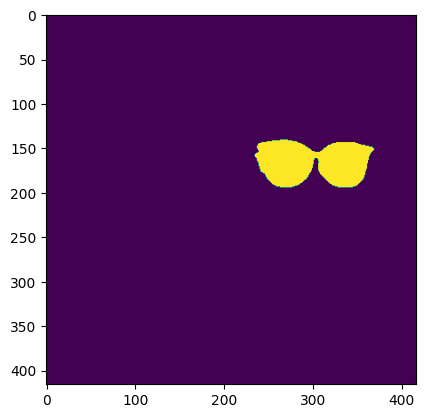

In [7]:


# path of  mask files
mask_file_path = '/home/ericnguyen/eric/master_thesis/src/grasp-anything/mask/0a35d0fd13323ae715e670a5e5074f9b07b8d2f4e70a1a852fbf1814d728aff6_0.npy'

# Load the mask using NumPy
mask = np.load(mask_file_path)

# Create a figure and plot the mask
fig, ax = plt.subplots(1)
ax.imshow(mask, cmap='viridis')  # Assuming the mask is a binary image

# Find the coordinates of non-zero pixels in the mask
y, x = np.nonzero(mask)

# Create rectangles around the non-zero pixels in the mask
for i in range(len(x)):
    rect = patches.Rectangle((x[i], y[i]), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Show the mask with grasp rectangles
plt.show()

After creating new dataset with the same number of items in each folders, check the name is matching in each folders.

In [26]:

def count_matching_items(positive_grasp_folder, positive_image_folder, positive_prompt_folder):
    grasp_files = os.listdir(positive_grasp_folder)
    image_files = os.listdir(positive_image_folder)
    prompt_files = os.listdir(positive_prompt_folder)

    matching_count = 0

    for grasp_file in grasp_files:
        # Extract the base name without extension and "_0"
        base_name = os.path.splitext(grasp_file)[0][:-2]

        # Check if corresponding image and prompt files exist
        if f"{base_name}.jpg" in image_files and f"{base_name}.pkl" in prompt_files:
            matching_count += 1

    return matching_count

# Example usage:
positive_grasp_folder = "/home/ericnguyen/eric/master_thesis/src/grasp-anything/new_dataset/positive_grasp"
positive_image_folder = "/home/ericnguyen/eric/master_thesis/src/grasp-anything/new_dataset/positive_images"
positive_prompt_folder = "/home/ericnguyen/eric/master_thesis/src/grasp-anything/new_dataset/positive_prompt"

matching_count = count_matching_items(positive_grasp_folder, positive_image_folder, positive_prompt_folder)
print(f"Number of matching items: {matching_count}")


Number of matching items: 1976


In [36]:

# Define the path to your Grasp-Anything dataset
dataset_path = "/home/ericnguyen/eric/master_thesis/src/grasp-anything/new_dataset"

def check_none_files(dataset_path):
    none_files = []

    # Assuming positive_grasp files are stored in the positive_grasp directory
    positive_grasp_dir = os.path.join(dataset_path, "positive_grasp")

    # Iterate through files in positive_grasp directory
    for file in os.listdir(positive_grasp_dir):
        file_path = os.path.join(positive_grasp_dir, file)

        try:
            positive_grasp = torch.load(file_path)
            if positive_grasp is None:
                none_files.append(file)
        except Exception as e:
            print(f"Error loading positive_grasp data at {file_path}: {e}")
            none_files.append(file)

    if none_files:
        print("Files with None positive_grasp:")
        for file in none_files:
            print(file)
    else:
        print("All files have valid positive_grasp data.")

# Call the function with your dataset_path
check_none_files(dataset_path)


All files have valid positive_grasp data.


***PROCESSING DATASET***

In [63]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Image preprocessing
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.convert("RGB")  # Ensure RGB format
    image = image.resize((224, 224))  # Resize to match CLIP's input size
    image = preprocess(image).unsqueeze(0).to(device)  # Preprocess for CLIP
    return image

# Text preprocessing
def preprocess_text(text):
    tokenized_text = clip.tokenize([text]).to(device)
    return tokenized_text

# Define the path to your Grasp-Anything dataset
dataset_path = "/home/ericnguyen/eric/master_thesis/src/grasp-anything/new_dataset"

batch_size = 8

# Define dataset class
class GraspDataset(Dataset):
    def __init__(self, dataset_path):
        self.image_paths = [os.path.join(dataset_path, "positive_images", file) for file in os.listdir(os.path.join(dataset_path, "positive_images"))]
        self.text_descriptions = [self.load_text_description(file) for file in os.listdir(os.path.join(dataset_path, "positive_prompt"))]
        self.positive_grasp_paths = [self.get_positive_grasp_path(file) for file in os.listdir(os.path.join(dataset_path, "positive_images"))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        text_description = self.text_descriptions[idx]
        positive_grasp = torch.load(self.positive_grasp_paths[idx])

        image = preprocess_image(image_path)
        text_tokens = preprocess_text(text_description)

        # max_size = max(grasp.size(0) for grasp in positive_grasp)
        # padded_positive_grasp = torch.zeros(len(positive_grasp), max_size, positive_grasp[0].size(1))

        # for i, grasp in enumerate(positive_grasp):
        #     padded_positive_grasp[i, :grasp.size(0), :] = grasp

        print(image.size(), text_tokens.size(), positive_grasp.size())
        return image, text_tokens, positive_grasp
    

    def load_text_description(self, file):
        prompt_path = os.path.join(dataset_path, "positive_prompt", file.replace(".jpg", ".pkl"))
        # Load and return the text description from the prompt file
        with open(prompt_path, 'rb') as f:
            text_description_tuple = pickle.load(f)

        if isinstance(text_description_tuple, tuple) and len(text_description_tuple) == 2:
            main_text, additional_info_list = text_description_tuple

            # Only keep the specified parts of the prompt
            additional_info_text = ' '.join(map(str, additional_info_list))

            # Modify this line to include only the desired parts
            text_description = additional_info_text
        elif isinstance(text_description_tuple, str):
            text_description = text_description_tuple
        else:
            raise TypeError(f"Unexpected data type for text description in {prompt_path}")

        return text_description

    def get_positive_grasp_path(self, file):
        base_name = os.path.splitext(file)[0] + "_0"
        return os.path.join(dataset_path, "positive_grasp", base_name + ".pt")


# New class that inherits from GraspDataset
class GraspSubset(GraspDataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)


# Create dataset and split into train, test, and validation sets
grasp_dataset = GraspDataset(dataset_path)
dataset_size = len(grasp_dataset)
train_size = int(0.8 * dataset_size)
test_size = (dataset_size - train_size) // 2
val_size = dataset_size - train_size - test_size

train_indices, test_indices, val_indices = random_split(list(range(dataset_size)), [train_size, test_size, val_size])

# Create data loaders for train, test, and validation sets
train_dataset = GraspSubset(grasp_dataset, train_indices)
test_dataset = GraspSubset(grasp_dataset, test_indices)
val_dataset = GraspSubset(grasp_dataset, val_indices)

# Define sub-batch size
sub_batch_size = batch_size // 2

# Create data loaders with sub-batch strategy
train_loader = DataLoader(train_dataset, batch_size=sub_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=sub_batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=sub_batch_size, shuffle=False)



Checking the input tensor size

In [64]:
for image_input, text_tokens_input, positive_grasp in train_loader:
        # Print the sizes of input tensors
        print(f" Image size: {image_input.size()}, Text size: {text_tokens_input.size()}, Grasp size: {positive_grasp.size()}")
    

torch.Size([1, 3, 224, 224]) torch.Size([1, 77]) torch.Size([1, 6])
torch.Size([1, 3, 224, 224]) torch.Size([1, 77]) torch.Size([3, 6])
torch.Size([1, 3, 224, 224]) torch.Size([1, 77]) torch.Size([11, 6])
torch.Size([1, 3, 224, 224]) torch.Size([1, 77]) torch.Size([7, 6])


RuntimeError: stack expects each tensor to be equal size, but got [1, 6] at entry 0 and [3, 6] at entry 1

***ARCHITECHTURE***

In [19]:


class MultiModalGenerativeResnet(GraspModel):
    def __init__(self, input_channels=4, text_feature_size=64, output_channels=1, channel_size=32, dropout=False, prob=0.0):
        super(MultiModalGenerativeResnet, self).__init__()

        # Image pathway
        self.image_conv1 = nn.Conv2d(input_channels, channel_size, kernel_size=9, stride=1, padding=4)
        self.bn1 = nn.BatchNorm2d(channel_size)

        # Common layers after merging
        self.merge_fc = nn.Linear(text_feature_size + (channel_size * 8 * 8), channel_size * 4)  # Combined features

        # Rest of the Antipodal model
        self.res1 = ResidualBlock(channel_size * 4, channel_size * 4)
        self.res2 = ResidualBlock(channel_size * 4, channel_size * 4)
        self.res3 = ResidualBlock(channel_size * 4, channel_size * 4)
        self.res4 = ResidualBlock(channel_size * 4, channel_size * 4)
        self.res5 = ResidualBlock(channel_size * 4, channel_size * 4)

        self.conv4 = nn.ConvTranspose2d(channel_size * 4, channel_size * 2, kernel_size=4, stride=2, padding=1,
                                        output_padding=1)
        self.bn4 = nn.BatchNorm2d(channel_size * 2)

        self.conv5 = nn.ConvTranspose2d(channel_size * 2, channel_size, kernel_size=4, stride=2, padding=2,
                                        output_padding=1)
        self.bn5 = nn.BatchNorm2d(channel_size)

        self.conv6 = nn.ConvTranspose2d(channel_size, channel_size, kernel_size=9, stride=1, padding=4)

        # Output layers for 5-dimensional grasp configuration
        self.pos_output = nn.Conv2d(in_channels=channel_size, out_channels=output_channels, kernel_size=2)
        self.height_output = nn.Conv2d(in_channels=channel_size, out_channels=output_channels, kernel_size=2)
        self.width_output = nn.Conv2d(in_channels=channel_size, out_channels=output_channels, kernel_size=2)
        self.theta_output = nn.Conv2d(in_channels=channel_size, out_channels=output_channels, kernel_size=2)

        self.dropout = dropout
        if self.dropout:
            self.dropout_pos = nn.Dropout(p=prob)
            self.dropout_height = nn.Dropout(p=prob)
            self.dropout_width = nn.Dropout(p=prob)
            self.dropout_theta = nn.Dropout(p=prob)

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.xavier_uniform_(m.weight, gain=1)

    def forward(self, image, text_features):
        # Image pathway
        x = F.relu(self.bn1(self.image_conv1(image)))
        # Flatten image features
        x_image = x_image.view(x.size(0), -1)  # Flatten to match dimensions

        # Flatten text features (assuming they're already in a suitable format)
        text_features = text_features.view(text_features.size(0), -1)

        # Combine image and text features
        combined_features = torch.cat((x_image, text_features), dim=1)
        combined_features = F.relu(self.merge_fc(combined_features))

        # Continue with the rest of the Antipodal model
        x = self.res1(combined_features)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.conv6(x)

       # Output layers for 5-dimensional grasp configuration
        if self.dropout:
            pos_output = self.pos_output(self.dropout_pos(combined_features))
            height_output = self.height_output(self.dropout_height(combined_features))
            width_output = self.width_output(self.dropout_width(combined_features))
            theta_output = self.theta_output(self.dropout_theta(combined_features))
        else:
            pos_output = self.pos_output(combined_features)
            height_output = self.height_output(combined_features)
            width_output = self.width_output(combined_features)
            theta_output = self.theta_output(combined_features)

        return pos_output, height_output, width_output, theta_output

    def compute_loss(self, image, text, yc):
        y_pos, y_height, y_width, y_theta = yc
        pos_pred, height_pred, width_pred, theta_pred = self(image, text)

        p_loss = F.smooth_l1_loss(pos_pred, y_pos)
        h_loss = F.smooth_l1_loss(height_pred, y_height)
        w_loss = F.smooth_l1_loss(width_pred, y_width)
        theta_loss = F.smooth_l1_loss(theta_pred, y_theta)

        return {
            'loss': p_loss + h_loss + w_loss + theta_loss,
            'losses': {
                'p_loss': p_loss,
                'h_loss': h_loss,
                'w_loss': w_loss,
                'theta_loss': theta_loss
            },
            'pred': {
                'pos': pos_pred,
                'height': height_pred,
                'width': width_pred,
                'theta': theta_pred
            }
        }


***TRAINING FUNCTION***

In [45]:
def train(epoch, net, device, train_loader, optimizer, batches_per_epoch, vis=False):
    results = {
        'loss': 0,
        'losses': {}
    }

    net.train()
    batch_idx = 0
    while batch_idx <= batches_per_epoch:
        for image_input, text_tokens_input, positive_grasp in train_loader:
        
            # Print the sizes of input tensors
            print(f"Batch {batch_idx}: Image size: {image_input.size()}, Text size: {text_tokens_input.size()}, Grasp size: {positive_grasp.size()}")
            batch_idx += 1
            if batch_idx >= batches_per_epoch:
                break
            
            # encode the image features as the inputs
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_tokens_input)
            image = image_features.to(device)
            text_tokens = text_features.to(device)

            grasp = [yy.to(device) for yy in positive_grasp]
            lossd = net.compute_loss(image, text_tokens, grasp)

            loss = lossd['loss']

            if batch_idx % 100 == 0:
                print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")

            results['loss'] += loss.item()
            for ln, l in lossd['losses'].items():
                if ln not in results['losses']:
                    results['losses'][ln] = 0
                results['losses'][ln] += l.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Display the images
            # if vis:
            #     imgs = []
            #     n_img = min(4, image_input.shape[0])
            #     for idx in range(n_img):
            #         imgs.extend([image_input[idx,].numpy().squeeze()] + [yi[idx,].numpy().squeeze() for yi in positive_grasp] + [
            #             image_input[idx,].numpy().squeeze()] + [pc[idx,].detach().cpu().numpy().squeeze() for pc in
            #                                           lossd['pred'].values()])
            #     gridshow('Display', imgs,
            #              [(image.min().item(), image.max().item()), (0.0, 1.0), (0.0, 1.0), (-1.0, 1.0),
            #               (0.0, 1.0)] * 2 * n_img,
            #              [cv2.COLORMAP_BONE] * 10 * n_img, 10)
            #     cv2.waitKey(2)


    results['loss'] /= batch_idx
    for key in results['losses']:
        results['losses'][key] /= batch_idx

    return results


***EVALUATE FUNCTION***

In [43]:


def evaluate(net, device, data_loader):
    net.eval()

    iou_threshold = 0.25  # You can adjust this threshold based on your task

    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for image_input, text_tokens_input, positive_grasp in data_loader:
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_tokens_input)
            image = image_features.to(device)
            text_tokens = text_features.to(device)

            grasp = [yy.to(device) for yy in positive_grasp]

            # Get predicted grasp parameters
            _, _, _, theta_pred = net(image, text_tokens)['pred'].values()

            # Convert grasp parameters to bounding boxes
            pred_bboxes = grasps_to_bboxes(theta_pred)

            # Convert ground truth grasp parameters to bounding boxes
            gt_bboxes = grasps_to_bboxes(grasp[0])

            # Compute IoU for each sample in the batch
            batch_iou = calculate_iou(pred_bboxes, gt_bboxes)

            total_iou += batch_iou.sum().item()
            total_samples += len(batch_iou)

    average_iou = total_iou / total_samples

    return average_iou

def grasps_to_bboxes(grasps):
    # convert grasp representation to bbox
    x = grasps[:, 0]
    y = grasps[:, 1]
    theta = grasps[:, 2]
    h = grasps[:, 3]
    w = grasps[:, 4]
    x1 = x - w/2 * torch.cos(theta) + h/2 * torch.sin(theta)
    y1 = y - w/2 * torch.sin(theta) - h/2 * torch.cos(theta)
    x2 = x + w/2 * torch.cos(theta) + h/2 * torch.sin(theta)
    y2 = y + w/2 * torch.sin(theta) - h/2 * torch.cos(theta)
    x3 = x + w/2 * torch.cos(theta) - h/2 * torch.sin(theta)
    y3 = y + w/2 * torch.sin(theta) + h/2 * torch.cos(theta)
    x4 = x - w/2 * torch.cos(theta) - h/2 * torch.sin(theta)
    y4 = y - w/2 * torch.sin(theta) + h/2 * torch.cos(theta)
    bboxes = torch.stack((x1, y1, x2, y2, x3, y3, x4, y4), 1)
    return bboxes

def calculate_iou(pred_bboxes, gt_bboxes):
    """
    Calculate Intersection over Union (IoU) between predicted and ground truth bounding boxes.
    """
    iou_list = []
    for pred_bbox, gt_bbox in zip(pred_bboxes, gt_bboxes):
        iou = box_iou(pred_bbox, gt_bbox)
        iou_list.append(iou.item())
    return torch.tensor(iou_list)

def box_iou(bbox_value, bbox_target):
    p1 = Polygon(bbox_value.view(-1, 2).tolist())
    p2 = Polygon(bbox_target.view(-1, 2).tolist())
    iou = p1.intersection(p2).area / (p1.area + p2.area - p1.intersection(p2).area)
    return iou


***TRAINING MODEL***

In [46]:


# Define your model
model = MultiModalGenerativeResnet()

# Define optimizer and other training parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5  # You can adjust this number based on your needs
batches_per_epoch = len(train_loader)

# Training loop
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")

    # Training
    train_results = train(epoch, model, device, train_loader, optimizer, batches_per_epoch)

    # Evaluation
    average_iou = evaluate(model, device, val_loader)
    print(f"Average IoU on Validation Set: {average_iou:.4f}")


print("Training and Evaluation completed.")

Epoch 1/5


RuntimeError: stack expects each tensor to be equal size, but got [3, 6] at entry 0 and [1, 6] at entry 2